In [1]:
import uproot as up
from cycler import cycler
import mplhep as hep
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path

plt.style.use(hep.style.CMS)

In [2]:
colorDict = {
    'DY+jets': '#e5ccff',
    r'$H\rightarrow b\bar{b}$':'#ccccff',
    'QCD': '#ffccff',
    'Diboson': '#ffff99',
    'Single t': '#ff9999',
    r'$t\bar{t}$': '#ffcc66',
    'W+jets': '#ccffcc',
    'Z+jets':'#99ffff'
}

processNames = {
    'qcdMC': 'QCD',
    'qcd': 'QCD',
    'tt': r'$t\bar{t}$',
    'ttMC': r'$t\bar{t}$',
    'stMC': 'Single t',
    'st': 'Single t',
    'vvMC': 'Diboson',
    'hbbMC': r'$H\rightarrow b\bar{b}$',
    'dyjetsMC': 'DY+jets',
    'wjets': 'W+jets',
    'wjetsMC': 'W+jets',
    'zjets': 'Z+jets',
    'zjetsMC': 'Z+jets'
    #'Mhs_50': 'Signal'
}
recoilDict = {
    '0':'[250, 310) GeV',
    '1':'[310, 370) GeV',
    '2':'[370, 470) GeV',
    '3':'[470, 590) GeV',
    '4':'[590, 3000] GeV'
}
regionDict = {
    'sr_pass':'Signal Region',
    'sr_fail':'Z+jets Control Region',
    'wecr_pass':'W+jets Single Electron \"Pass\" Control Region',
    'wecr_fail':'W+jets Single Electron \"Fail\" Control Region',
    'wmcr_pass':'W+jets Single Muon \"Pass\" Control Region',
    'wmcr_fail':'W+jets Single Muon \"Fail\" Control Region',
    'tecr_pass':'Top-Pair Single Electron Control Region',
    'tmcr_pass':'Top-Pair Single Muon Control Region',
}
mc_labels40to120 = ['DY+jets','Z+jets', r'$H\rightarrow b\bar{b}$', 
                    'QCD', 'Diboson', 'Single t', r'$t\bar{t}$', 'W+jets']
mc_labels120to300 = ['DY+jets', 'Z+jets', r'$H\rightarrow b\bar{b}$', 
                     'QCD', 'Diboson', 'Single t', r'$t\bar{t}$', 'W+jets']

In [16]:
def plot_postfit(f, region, year, processes40to120, processes120to300, saveplot=False):
    
    def extract(recoil, category):
        identifier40to120 = region+year+category+'mass40to120recoil'+recoil
        identifier120to300 = region+year+category+'mass120to300recoil'+recoil

        prefit_dir40to120 = f[identifier40to120+'_prefit']
        postfit_dir40to120 = f[identifier40to120+'_postfit']

        prefit_dir120to300 = f[identifier120to300+'_prefit']
        postfit_dir120to300 = f[identifier120to300+'_postfit']

        totbkg40to120 = prefit_dir40to120["TotalBkg"].values
        edges40to120 = prefit_dir40to120["TotalBkg"].edges

        totbkg120to300 = prefit_dir120to300["TotalBkg"].values
        edges120to300 = prefit_dir120to300["TotalBkg"].edges[1:] ## to remove duplicate edge

        totbkg = np.concatenate((totbkg40to120, totbkg120to300), axis=None)
        edges = np.concatenate((edges40to120, edges120to300), axis=None)

        ### Move to draw postfit
        sum_prefit = np.zeros(len(edges)-1)
        sum_postfit = np.zeros(len(edges)-1)
        sum_postfit_variance = np.zeros(len(edges)-1)
        process_bin = []
        mc_list = []

        keys40to120 = []
        for i in postfit_dir40to120.keys():
            keys40to120.append(str(i).replace('b\'','').replace(';1\'',''))
        keys120to300 = []
        for i in postfit_dir120to300.keys():
            keys120to300.append(str(i).replace('b\'','').replace(';1\'',''))

        for (i, j) in zip(processes40to120, processes120to300):
            #print('Which process', i, j)
            if not i in keys40to120:
                #print('Not found, skip this process')
                #print('Remove its label too \n')
                continue
            else:
                prefit40to120 = prefit_dir40to120[i].values
                postfit40to120 = postfit_dir40to120[i].values
                postfit40to120_variance = np.minimum(postfit40to120, postfit_dir40to120[i].variances)

            if not j in keys120to300:
                #print('Not found, skip this process')
                #print('Remove its label too \n')
                continue
            else:
                prefit120to300 = prefit_dir120to300[j].values
                postfit120to300 = postfit_dir120to300[j].values
                postfit120to300_variance = np.minimum(postfit120to300, postfit_dir120to300[j].variances)

            prefit_bin = np.concatenate((prefit40to120, prefit120to300), axis=None)
            postfit_bin = np.concatenate((postfit40to120, postfit120to300), axis=None)
            postfit_bin_variance = np.concatenate((postfit40to120_variance, postfit120to300_variance), axis=None)
            sum_prefit += prefit_bin
            sum_postfit += postfit_bin
            sum_postfit_variance += postfit_bin_variance
            process_bin.append(postfit_bin.tolist())
            mc_list.append(processNames[j])

        prefit = sum_prefit
        postfit = sum_postfit
        postfit_variance = sum_postfit_variance
        data40to120 = postfit_dir40to120["data_obs"].values
        data120to300 = postfit_dir120to300["data_obs"].values
        data = np.concatenate((data40to120, data120to300), axis=None)
        
        return data, prefit, postfit, mc_list, process_bin, edges, postfit_variance
    
    
    def fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, recoil):
        
        colors=[]
        for x in mc_list:
            colors.append(colorDict[x])
        colors.reverse()

        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.set_yscale('log')
        ax.set_ylim(1e-2, 10e+7)
        #ax.text(s='Recoil $\in$ '+recoilDict[recoil], y=1.5e+5, x=50, fontsize=15, weight='bold')

        ax.set_prop_cycle(cycler(color=colors))

        ### Try to draw stack plots
        hep.histplot(process_bin, edges, ax=ax, stack=True, 
                     histtype='fill', edgecolor = 'k', linewidth=1, label=mc_list)

        ### Draw stat uncs.
        y1 = postfit - np.sqrt(postfit_variance)
        y1 = np.append(y1, 0)
        y2 = postfit + np.sqrt(postfit_variance)
        y2 = np.append(y2, 0)
        ax.fill_between(
            x = edges,
            y1 = y1,
            y2 = y2,
            step = 'post',
            **errps, label='Unc.'
        )

        hep.histplot(postfit, edges, ax=ax, label=["SM total (post-fit)"], color='b', linewidth=3)
        hep.histplot(prefit, edges, ax=ax, label=["SM total (pre-fit)"], color='r', 
                     linestyle='dashed', linewidth=2)

        ### Call data ###
        hep.histplot(data, edges, ax=ax, histtype='errorbar', label="Data", color='k')
        
        handles, labels = ax.get_legend_handles_labels()
        order = list(range(len(labels)-1))
        order.insert(0, len(labels)-1)
        #LEGEND HERE
        #ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
        #             loc='upper right', fontsize=30, ncol=2)#, bbox_to_anchor=(5, 1))

        #handles, labels = ax.get_legend_handles_labels()
        #print(handles, labels)
        #order = [9,1,0,2,3,4,5,6,7,8]
        #ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],


        ### Drawing in ratio axes ###
        hep.histplot(data/prefit, edges, yerr=np.sqrt(data)/prefit, ax=rax, histtype='errorbar', 
                     color='r', capsize=4, label="Prefit")
        hep.histplot(data/postfit, edges, yerr=np.sqrt(data)/postfit, ax=rax, histtype='errorbar', 
                     color='b', capsize=4, label="Postfit")

        y1 = 1.- np.sqrt(postfit)/postfit
        y1 = np.append(y1, 0)
        y2 = 1.+ np.sqrt(postfit)/postfit
        y2 = np.append(y2, 0)

        rax.fill_between(
            x = edges,
            y1 = y1,
            y2 = y2,
            step='post',
           **errps, label='Bkg Uncs.'
        )

        rax.axhline(1, ls='--', color='k')
        ymax=abs(rax.get_ylim()[1])*1.1
        ymin=1.-(ymax-1.)
        rax.set_ylim(max(ymin,0),min(ymax,2))
        rax.set_xlim(40, 300)
        
        handles, labels = rax.get_legend_handles_labels()
        order = [1, 2, 0]
        #LEGEND HERE
        #rax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
        #           loc='upper right', fontsize=30, ncol=3)
    

    #fig = plt.figure()
    #gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    #axs = gs.subplots(sharex='col', sharey='row')

    
    if 't' not in region:
        fig, axs = plt.subplots(4, 5, figsize=(40,20), sharex='col', sharey='row',
                                gridspec_kw=dict(height_ratios=[3, 1, 3, 1], hspace=0.07, wspace=0.))
                                      #gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07), sharex=True)
        errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.3}

        ###
        # Pass
        ###

        ax=axs[0][0]
        rax=axs[1][0]

        ax.set_ylabel('Events/GeV', fontsize=20)
        hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
        #hep.cms.label(ax=ax, loc=0, lumi=lumi, year=year, llabel='Preliminary',fontsize=20)
        #rax.set_xlabel('AK15 Soft-Drop Mass [GeV]', fontsize=20)
        rax.set_ylabel('Obs/Exp', fontsize=20)#, loc='center')

        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('0','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '0')
        ax.text(s='$U$ $\in$ [250, 310) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'sr' in region:
            ax.text(s='Signal Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)

        ax=axs[0][1]
        rax=axs[1][1]
        ax.set_xticks([50,100,150,200,250])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('1','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '1')
        ax.text(s='$U$ $\in$ [310, 370) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'sr' in region:
            ax.text(s='Signal Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)

        ax=axs[0][2]
        rax=axs[1][2]
        ax.set_xticks([50,100,150,200,250])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('2','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '2')
        #ax.set_title(regionDict[region+'_'+category], loc='center', fontsize=25,y=1.1)
        ax.text(s='$U$ $\in$ [370, 470) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'sr' in region:
            ax.text(s='Signal Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)

        ax=axs[0][3]
        rax=axs[1][3]
        ax.set_xticks([50,100,150,200,250])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('3','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '3')
        ax.text(s='$U$ $\in$ [470, 590) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'sr' in region:
            ax.text(s='Signal Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)

        ax=axs[0][4]
        rax=axs[1][4]
        ax.set_xticks([50,100,150,200,250,300])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('4','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '4')
        ax.text(s='$U$ $\in$ [590, inf] GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25) 
        if 'sr' in region:
            ax.text(s='Signal Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Pass\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)

        ###
        # Fail
        ###

        ax=axs[2][0]
        rax=axs[3][0]

        ax.set_ylabel('Events/GeV', fontsize=20)
        rax.set_ylabel('Obs/Exp', fontsize=20)#, loc='center')

        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('0','fail')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '0')
        ax.text(s='$U$ $\in$ [250, 310) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'sr' in region:
            ax.text(s='Z+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)


        ax=axs[2][1]
        rax=axs[3][1]
        ax.set_xticks([50,100,150,200,250])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('1','fail')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '1')
        ax.text(s='$U$ $\in$ [310, 370) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'sr' in region:
            ax.text(s='Z+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)


        ax=axs[2][2]
        rax=axs[3][2]
        ax.set_xticks([50,100,150,200,250])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('2','fail')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '2')
        #ax.set_title(regionDict[region+'_'+category], loc='center', fontsize=25,y=1.1)
        rax.set_xlabel('AK15 Soft-Drop Mass [GeV]', fontsize=25)
        ax.text(s='$U$ $\in$ [370, 470) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'sr' in region:
            ax.text(s='Z+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)

        ax=axs[2][3]
        rax=axs[3][3]
        ax.set_xticks([50,100,150,200,250])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('3','fail')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '3')
        ax.text(s='$U$ $\in$ [470, 590) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'sr' in region:
            ax.text(s='Z+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)

        ax=axs[2][4]
        rax=axs[3][4]
        ax.set_xticks([50,100,150,200,250,300])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('4','fail')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '4')
        ax.text(s='$U$ $\in$ [590, inf] GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'sr' in region:
            ax.text(s='Z+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        if 'wmcr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
        if 'wecr' in region:
            ax.text(s='W+jets Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            ax.text(s='\"Fail\"',x=0.02,y=0.78, fontsize=15,transform=ax.transAxes)
    
    else:
        fig, axs = plt.subplots(2, 5, figsize=(40,10), sharex='col', sharey='row',
                                gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07, wspace=0.))
                                      #gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07), sharex=True)
        errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.3}

        ###
        # Pass
        ###

        ax=axs[0][0]
        rax=axs[1][0]

        ax.set_ylabel('Events/GeV', fontsize=20)
        hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
        #hep.cms.label(ax=ax, loc=0, lumi=lumi, year=year, llabel='Preliminary',fontsize=20)
        #rax.set_xlabel('AK15 Soft-Drop Mass [GeV]', fontsize=20)
        rax.set_ylabel('Obs/Exp', fontsize=20)#, loc='center')

        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('0','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '0')
        ax.text(s='$U$ $\in$ [250, 310) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'tmcr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        if 'tecr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)

        ax=axs[0][1]
        rax=axs[1][1]
        ax.set_xticks([50,100,150,200,250])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('1','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '1')
        ax.text(s='$U$ $\in$ [310, 370) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'tmcr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        if 'tecr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)



        ax=axs[0][2]
        rax=axs[1][2]
        ax.set_xticks([50,100,150,200,250])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('2','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '2')
        #ax.set_title(regionDict[region+'_'+category], loc='center', fontsize=25,y=1.1)
        ax.text(s='$U$ $\in$ [370, 470) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        rax.set_xlabel('AK15 Soft-Drop Mass [GeV]', fontsize=25)
        if 'tmcr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        if 'tecr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)

        ax=axs[0][3]
        rax=axs[1][3]
        ax.set_xticks([50,100,150,200,250])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('3','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '3')
        ax.text(s='$U$ $\in$ [470, 590) GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        if 'tmcr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        if 'tecr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)

        ax=axs[0][4]
        rax=axs[1][4]
        ax.set_xticks([50,100,150,200,250,300])
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('4','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '4')
        ax.text(s='$U$ $\in$ [590, inf] GeV',x=0.02,y=0.93, fontsize=15,transform=ax.transAxes)
        hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25) 
        if 'tmcr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        if 'tecr' in region:
            ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
            ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
            
    os.system('mkdir -p ../plots/darkhiggs/postfit/'+year+'/')
    plot_path = os.path.abspath('../plots/darkhiggs/postfit/'+year+'/')
    plot_name = region+year+'.png'
    
    if saveplot:
        fig.savefig(os.path.join(plot_path, plot_name))

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


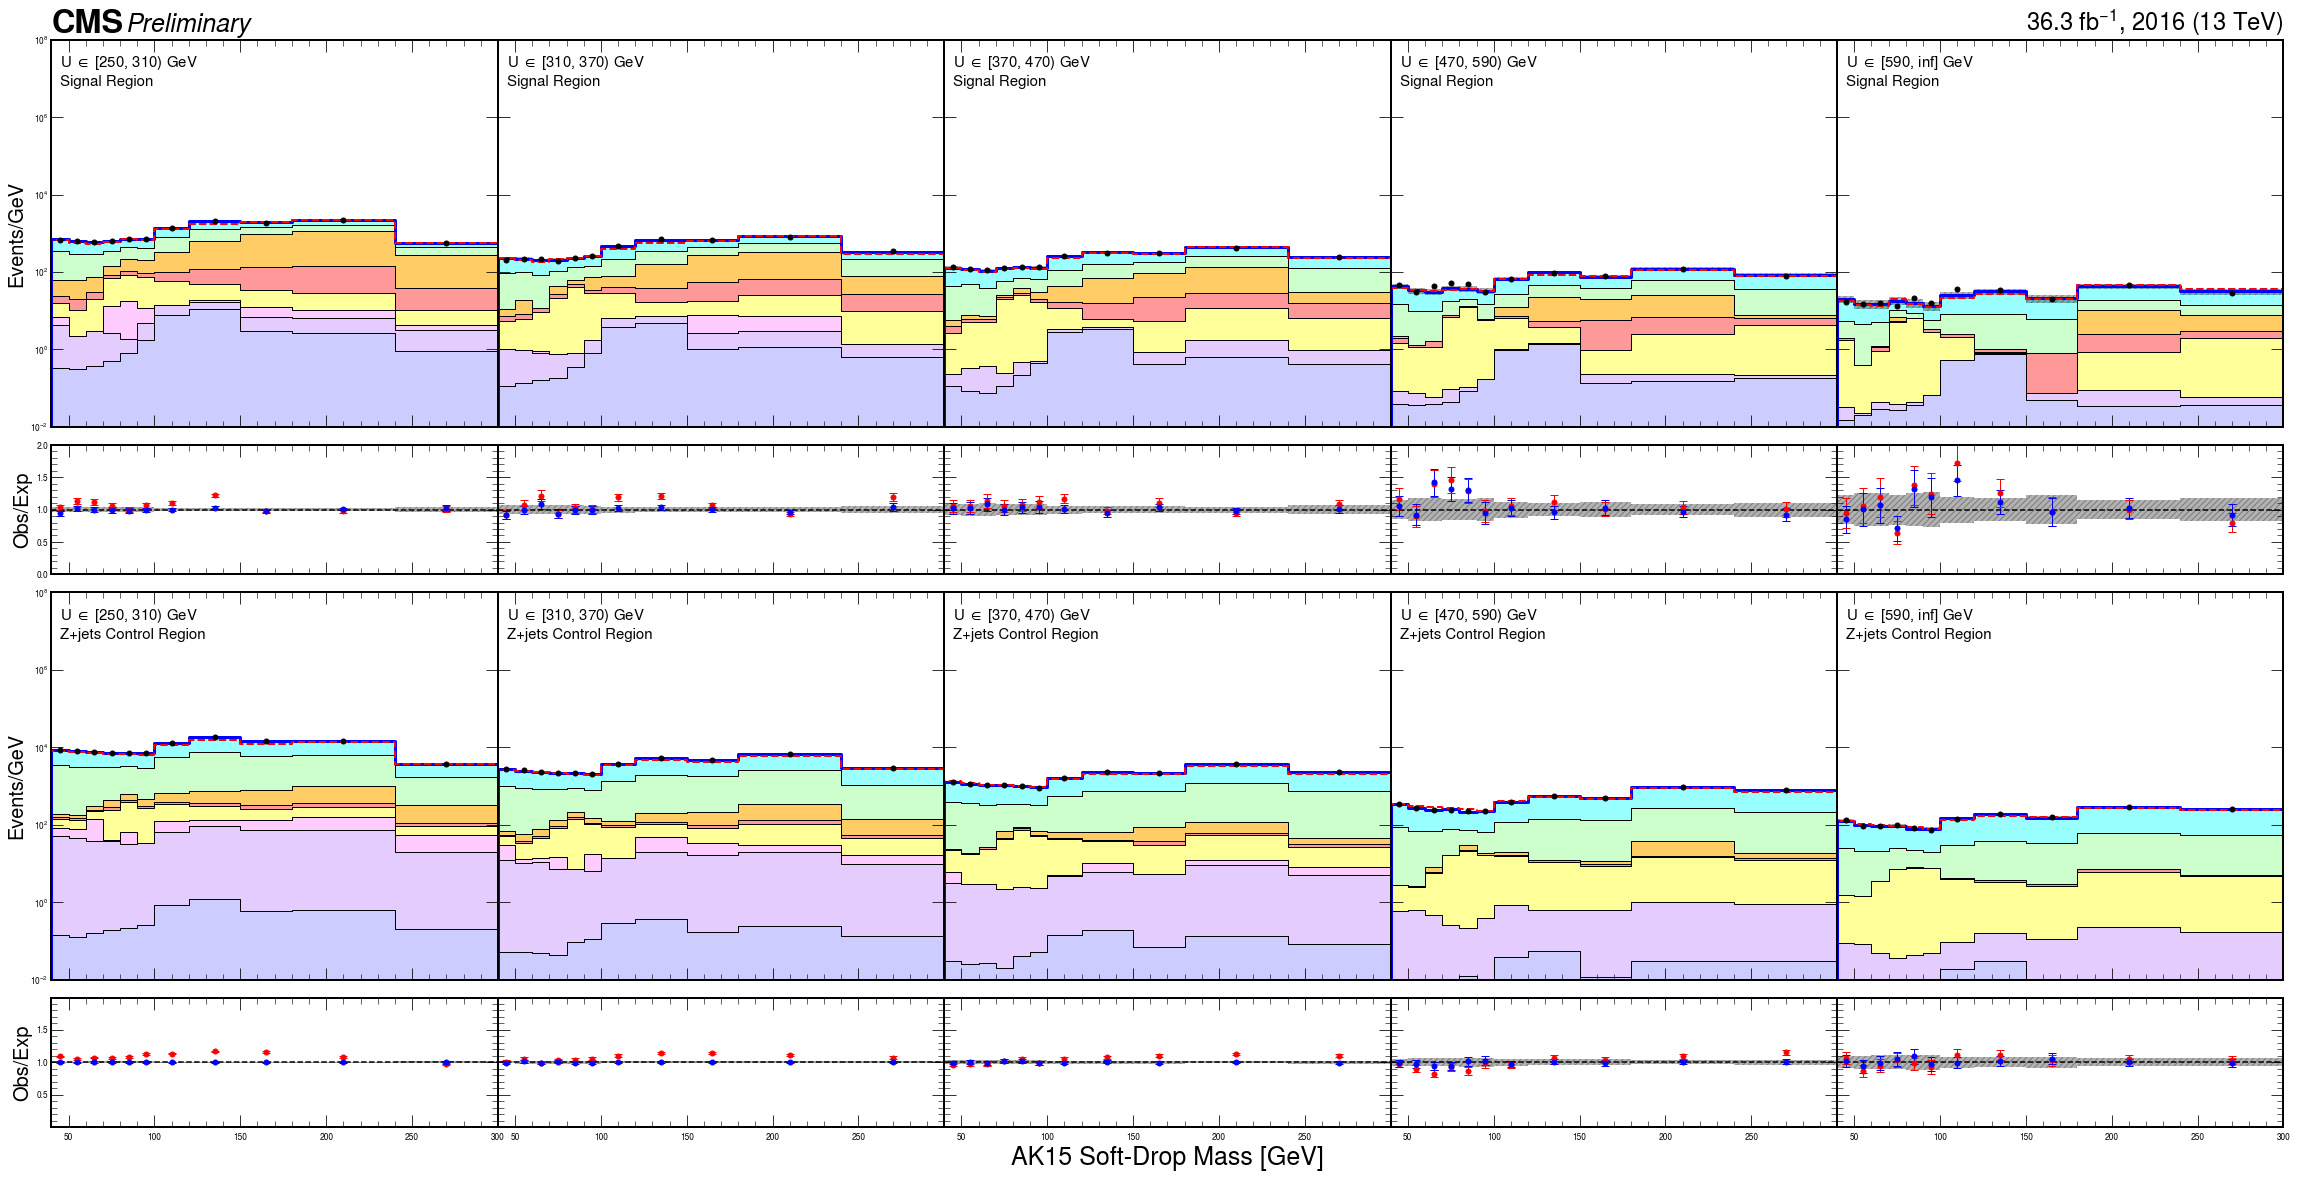

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


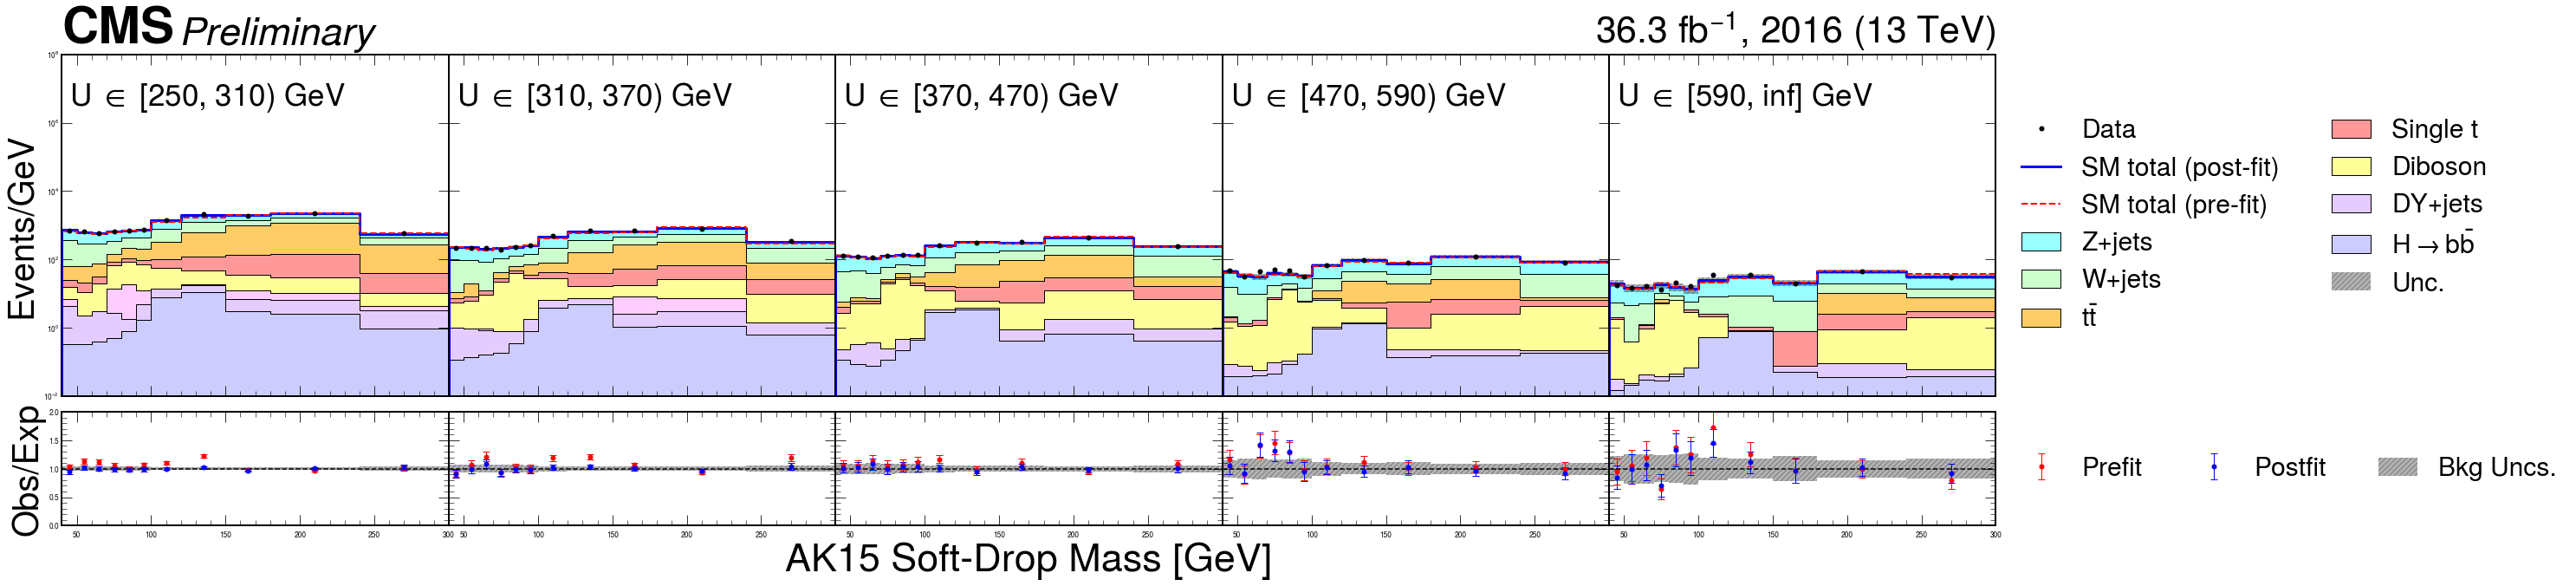

In [17]:
saveplot = True

year = '2016'

lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': "36.3",
        '2017': "41.5",
        '2018': "59.7"
    }
lumi=lumis[year]

f = up.open("../hists/darkhiggs.postfit")

processes40to120 = ['hbbMC', 'dyjetsMC', 'qcdMC', 'vvMC', 'stMC', 'ttMC', 'ttMC', 'wjets', 'wjetsMC', 'zjets', 'zjetsMC']
processes120to300 = ['hbbMC', 'dyjetsMC', 'qcdMC', 'vvMC', 'stMC', 'tt',  'ttMC', 'wjets', 'wjetsMC', 'zjets', 'zjetsMC']

plot_postfit(f, 'sr', year, processes40to120, processes120to300, saveplot)
#plot_postfit(f, 'wecr', year, processes40to120, processes120to300, saveplot)
#plot_postfit(f, 'wmcr', year, processes40to120, processes120to300, saveplot)
#plot_postfit(f, 'tecr', year, processes40to120, processes120to300, saveplot)
#plot_postfit(f, 'tmcr', year, processes40to120, processes120to300, saveplot)

In [9]:
def plot_postfit(f, region, year, processes40to120, processes120to300, saveplot=False):
    
    def extract(recoil, category):
        identifier40to120 = region+year+category+'mass40to120recoil'+recoil
        identifier120to300 = region+year+category+'mass120to300recoil'+recoil

        prefit_dir40to120 = f[identifier40to120+'_prefit']
        postfit_dir40to120 = f[identifier40to120+'_postfit']

        prefit_dir120to300 = f[identifier120to300+'_prefit']
        postfit_dir120to300 = f[identifier120to300+'_postfit']

        totbkg40to120 = prefit_dir40to120["TotalBkg"].values
        edges40to120 = prefit_dir40to120["TotalBkg"].edges

        totbkg120to300 = prefit_dir120to300["TotalBkg"].values
        edges120to300 = prefit_dir120to300["TotalBkg"].edges[1:] ## to remove duplicate edge

        totbkg = np.concatenate((totbkg40to120, totbkg120to300), axis=None)
        edges = np.concatenate((edges40to120, edges120to300), axis=None)

        ### Move to draw postfit
        sum_prefit = np.zeros(len(edges)-1)
        sum_postfit = np.zeros(len(edges)-1)
        sum_postfit_variance = np.zeros(len(edges)-1)
        process_bin = []
        mc_list = []

        keys40to120 = []
        for i in postfit_dir40to120.keys():
            keys40to120.append(str(i).replace('b\'','').replace(';1\'',''))
        keys120to300 = []
        for i in postfit_dir120to300.keys():
            keys120to300.append(str(i).replace('b\'','').replace(';1\'',''))

        for (i, j) in zip(processes40to120, processes120to300):
            #print('Which process', i, j)
            if not i in keys40to120:
                #print('Not found, skip this process')
                #print('Remove its label too \n')
                continue
            else:
                prefit40to120 = prefit_dir40to120[i].values
                postfit40to120 = postfit_dir40to120[i].values
                postfit40to120_variance = np.minimum(postfit40to120, postfit_dir40to120[i].variances)

            if not j in keys120to300:
                #print('Not found, skip this process')
                #print('Remove its label too \n')
                continue
            else:
                prefit120to300 = prefit_dir120to300[j].values
                postfit120to300 = postfit_dir120to300[j].values
                postfit120to300_variance = np.minimum(postfit120to300, postfit_dir120to300[j].variances)

            prefit_bin = np.concatenate((prefit40to120, prefit120to300), axis=None)
            postfit_bin = np.concatenate((postfit40to120, postfit120to300), axis=None)
            postfit_bin_variance = np.concatenate((postfit40to120_variance, postfit120to300_variance), axis=None)
            sum_prefit += prefit_bin
            sum_postfit += postfit_bin
            sum_postfit_variance += postfit_bin_variance
            process_bin.append(postfit_bin.tolist())
            mc_list.append(processNames[j])

        prefit = sum_prefit
        postfit = sum_postfit
        postfit_variance = sum_postfit_variance
        data40to120 = postfit_dir40to120["data_obs"].values
        data120to300 = postfit_dir120to300["data_obs"].values
        data = np.concatenate((data40to120, data120to300), axis=None)
        
        return data, prefit, postfit, mc_list, process_bin, edges, postfit_variance
    
    
    def fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, recoil):
        
        colors=[]
        for x in mc_list:
            colors.append(colorDict[x])
        colors.reverse()

        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 10}
        ax.set_yscale('log')
        ax.set_ylim(1e-2, 1e+5)
        #ax.text(s='Recoil $\in$ '+recoilDict[recoil], y=1.5e+5, x=50, fontsize=15, weight='bold')

        ax.set_prop_cycle(cycler(color=colors))

        ### Try to draw stack plots
        hep.histplot(process_bin, edges, ax=ax, stack=True, 
                     histtype='fill', edgecolor = 'k', linewidth=3, label=mc_list)

        ### Draw stat uncs.
        y1 = postfit - np.sqrt(postfit_variance)
        y1 = np.append(y1, 0)
        y2 = postfit + np.sqrt(postfit_variance)
        y2 = np.append(y2, 0)
        ax.fill_between(
            x = edges,
            y1 = y1,
            y2 = y2,
            step = 'post',
            **errps, label='Unc.'
        )

        hep.histplot(postfit, edges, ax=ax, label=["SM total (post-fit)"], color='b', linewidth=6)
        hep.histplot(prefit, edges, ax=ax, label=["SM total (pre-fit)"], color='r', 
                     linestyle='dashed', linewidth=6)

        ### Call data ###
        hep.histplot(data, edges, ax=ax, histtype='errorbar', label="Data", color='k', markersize=20)
        
        handles, labels = ax.get_legend_handles_labels()
        order = list(range(len(labels)-1))
        order.insert(0, len(labels)-1)
        #LEGEND HERE
        #ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
        #             loc='upper right', fontsize=30, ncol=2)#, bbox_to_anchor=(5, 1))

        #handles, labels = ax.get_legend_handles_labels()
        #print(handles, labels)
        #order = [9,1,0,2,3,4,5,6,7,8]
        #ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],


        ### Drawing in ratio axes ###
        hep.histplot(data/prefit, edges, yerr=np.sqrt(data)/prefit, ax=rax, histtype='errorbar', 
                     color='r', capsize=10, label="Prefit", markersize=20)
        hep.histplot(data/postfit, edges, yerr=np.sqrt(data)/postfit, ax=rax, histtype='errorbar', 
                     color='b', capsize=10, label="Postfit", markersize=20)

        y1 = 1.- np.sqrt(postfit)/postfit
        y1 = np.append(y1, 0)
        y2 = 1.+ np.sqrt(postfit)/postfit
        y2 = np.append(y2, 0)

        rax.fill_between(
            x = edges,
            y1 = y1,
            y2 = y2,
            step='post',
           **errps, label='Bkg Uncs.'
        )

        rax.axhline(1, ls='--', color='k')
        ymax=abs(rax.get_ylim()[1])*1.1
        ymin=1.-(ymax-1.)
        rax.set_ylim(max(ymin,0),min(ymax,2))
        rax.set_xlim(40, 300)
        
        handles, labels = rax.get_legend_handles_labels()
        order = [1, 2, 0]
        #LEGEND HERE
        #rax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
        #           loc='upper right', fontsize=30, ncol=3)
    

    #fig = plt.figure()
    #gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    #axs = gs.subplots(sharex='col', sharey='row')

    
    
    
    if 'sr' in region:
        fig, axs = plt.subplots(2, 5, figsize=(40,10), sharex='col', sharey='row',
                                gridspec_kw=dict(height_ratios=[3, 1], hspace=0.15, wspace=0.))
                                      #gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07), sharex=True)
        errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.3}

        ###
        # Pass
        ###

        ax=axs[0][0]
        rax=axs[1][0]

        ax.set_ylabel('Events/GeV', fontsize=40)
        ax.tick_params(axis='y', labelsize=30)
        ax.set_xticks([50,100,150,200,250])
        hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=45)
        #hep.cms.label(ax=ax, loc=0, lumi=lumi, year=year, llabel='Preliminary',fontsize=20)
        #rax.set_xlabel('AK15 Soft-Drop Mass [GeV]', fontsize=20)
        rax.set_ylabel('Obs/Exp', fontsize=40)#, loc='center')
        rax.tick_params(axis='y', labelsize=30)
        rax.tick_params(axis='x', labelsize=30)

        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('0','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '0')
        ax.text(s='$U$ $\in$ [250, 310) GeV',x=0.02,y=0.88, fontsize=35,transform=ax.transAxes)
        #if 'tmcr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        #if 'tecr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)

        ax=axs[0][1]
        rax=axs[1][1]
        ax.set_xticks([50,100,150,200,250])
        rax.tick_params(axis='x', labelsize=30)
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('1','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '1')
        ax.text(s='$U$ $\in$ [310, 370) GeV',x=0.02,y=0.88, fontsize=35,transform=ax.transAxes)
        #if 'tmcr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        #if 'tecr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)



        ax=axs[0][2]
        rax=axs[1][2]
        ax.set_xticks([50,100,150,200,250])
        rax.tick_params(axis='x', labelsize=30)
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('2','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '2')
        #ax.set_title(regionDict[region+'_'+category], loc='center', fontsize=25,y=1.1)
        ax.text(s='$U$ $\in$ [370, 470) GeV',x=0.02,y=0.88, fontsize=35,transform=ax.transAxes)
        rax.set_xlabel('AK15 Soft-Drop Mass [GeV]', fontsize=45)
        #if 'tmcr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        #if 'tecr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)

        ax=axs[0][3]
        rax=axs[1][3]
        ax.set_xticks([50,100,150,200,250])
        rax.tick_params(axis='x', labelsize=30)
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('3','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '3')
        ax.text(s='$U$ $\in$ [470, 590) GeV',x=0.02,y=0.88, fontsize=35,transform=ax.transAxes)
        #if 'tmcr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        #if 'tecr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)

        ax=axs[0][4]
        rax=axs[1][4]
        ax.set_xticks([50,100,150,200,250,300])
        rax.tick_params(axis='x', labelsize=30)
        data, prefit, postfit, mc_list, process_bin, edges, postfit_variance = extract('4','pass')
        fill(data, prefit, postfit, mc_list, process_bin, edges, postfit_variance, ax, rax, '4')
        ax.text(s='$U$ $\in$ [590, inf] GeV',x=0.02,y=0.88, fontsize=35,transform=ax.transAxes)
        hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=45) 
        #if 'tmcr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Muon',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        #if 'tecr' in region:
        #    ax.text(s=r'$t\bar{t}$ Control Region',x=0.02,y=0.88, fontsize=15,transform=ax.transAxes)
        #    ax.text(s='Single Electron',x=0.02,y=0.83, fontsize=15,transform=ax.transAxes)
        handles, labels = ax.get_legend_handles_labels()
        order = list(range(len(labels)-1))
        order.insert(0, len(labels)-1)
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                     loc='center left', fontsize=35, ncol=2, bbox_to_anchor=(1, 0.5))
        handles, labels = rax.get_legend_handles_labels()
        order = [1, 2, 0]
        rax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
                   loc='center left', fontsize=35, ncol=3, bbox_to_anchor=(1, 0.5))
    
        os.system('mkdir -p ../plots/darkhiggs/postfit/'+year+'/')
        plot_path = os.path.abspath('../plots/darkhiggs/postfit/'+year+'/')
        plot_name = 'sr_pass'+year+'.pdf'
    
    if saveplot:
        fig.savefig(os.path.join(plot_path, plot_name))

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a

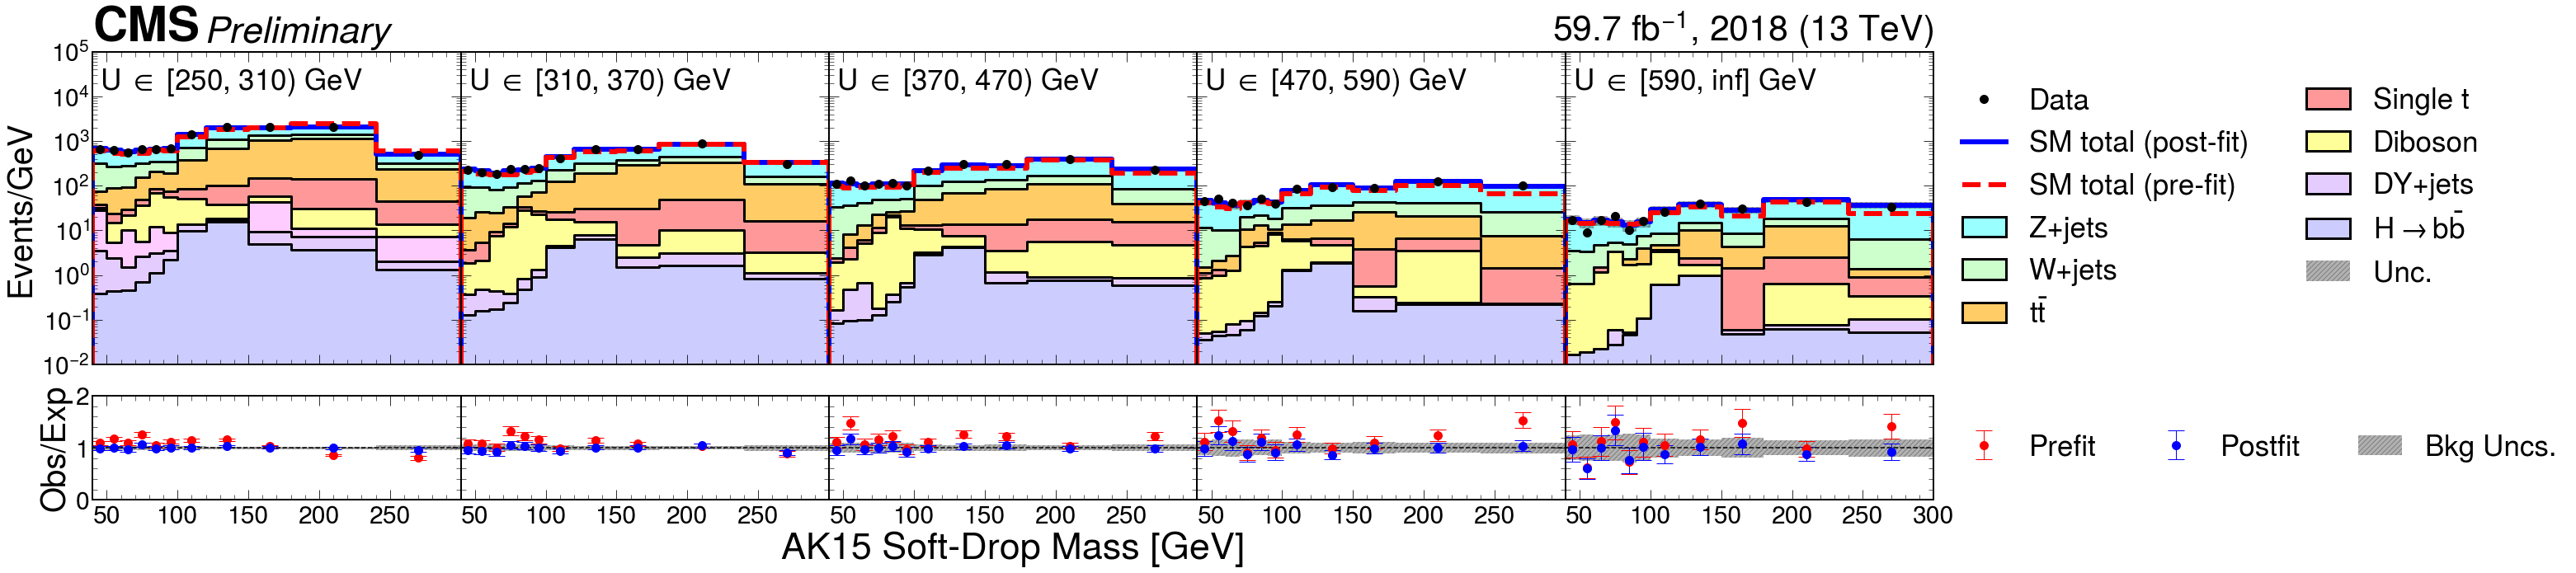

In [10]:
saveplot = True

year = '2018'

lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': "36.3",
        '2017': "41.5",
        '2018': "59.7"
    }
lumi=lumis[year]

f = up.open("../hists/darkhiggs.postfit")

processes40to120 = ['hbbMC', 'dyjetsMC', 'qcdMC', 'vvMC', 'stMC', 'ttMC', 'ttMC', 'wjets', 'wjetsMC', 'zjets', 'zjetsMC']
processes120to300 = ['hbbMC', 'dyjetsMC', 'qcdMC', 'vvMC', 'stMC', 'tt',  'ttMC', 'wjets', 'wjetsMC', 'zjets', 'zjetsMC']

plot_postfit(f, 'sr', year, processes40to120, processes120to300, saveplot)
#plot_postfit(f, 'wecr', year, processes40to120, processes120to300, saveplot)
#plot_postfit(f, 'wmcr', year, processes40to120, processes120to300, saveplot)
#plot_postfit(f, 'tecr', year, processes40to120, processes120to300, saveplot)
#plot_postfit(f, 'tmcr', year, processes40to120, processes120to300, saveplot)

# Single postfit plot per category

## Save yields per recoil and process in pandas

In [ ]:
def save_yields_in_pandas(f, region, year, category, processes):
    data = {}

    # Return edges
    identifier40to120 = region + year + category + 'mass40to120recoil0'
    identifier120to300 = region + year + category + 'mass120to300recoil0'

    postfit_dir40to120 = f[identifier40to120 + '_postfit']
    postfit_dir120to300 = f[identifier120to300 + '_postfit']

    edges40to120 = postfit_dir40to120["TotalBkg"].edges
    edges120to300 = postfit_dir120to300["TotalBkg"].edges[1:]  # Remove duplicate edge
    edges = np.concatenate((edges40to120, edges120to300), axis=None)

    for recoil in range(5):
        identifier40to120 = region + year + category + 'mass40to120recoil' + str(recoil)
        identifier120to300 = region + year + category + 'mass120to300recoil' + str(recoil)

        prefit_dir40to120 = f[identifier40to120 + '_prefit']
        postfit_dir40to120 = f[identifier40to120 + '_postfit']
        prefit_dir120to300 = f[identifier120to300 + '_prefit']
        postfit_dir120to300 = f[identifier120to300 + '_postfit']

        keys40to120 = [str(i).replace('b\'', '').replace(';1\'', '') for i in postfit_dir40to120.keys()]
        keys120to300 = [str(i).replace('b\'', '').replace(';1\'', '') for i in postfit_dir120to300.keys()]

        for process in processes:
            if process not in keys40to120 or process not in keys120to300:
                continue

            prefit40to120 = prefit_dir40to120[process].values
            postfit40to120 = postfit_dir40to120[process].values
            postfit40to120_variance = np.minimum(postfit40to120, postfit_dir40to120[process].variances)

            prefit120to300 = prefit_dir120to300[process].values
            postfit120to300 = postfit_dir120to300[process].values
            postfit120to300_variance = np.minimum(postfit120to300, postfit_dir120to300[process].variances)

            prefit_bin = np.concatenate((prefit40to120, prefit120to300), axis=None)
            postfit_bin = np.concatenate((postfit40to120, postfit120to300), axis=None)
            postfit_bin_variance = np.concatenate((postfit40to120_variance, postfit120to300_variance), axis=None)

            name = process.replace('MC', '')
            data[f"{name}_recoil{recoil}_prefit"] = prefit_bin
            data[f"{name}_recoil{recoil}_postfit"] = postfit_bin
            data[f"{name}_recoil{recoil}_var"] = postfit_bin_variance

        # Data
        data40to120 = postfit_dir40to120["data_obs"].values
        data120to300 = postfit_dir120to300["data_obs"].values
        data_contents = np.concatenate((data40to120, data120to300), axis=None)
        data[f"data_recoil{recoil}_obs"] = data_contents

    yields_df = pd.DataFrame.from_dict(data)
    outdir = Path(f'./{region}_{year}_{category}')
    outdir.mkdir(exist_ok=True)
    outfile = outdir / "yields.csv"
    yields_df.to_csv(outfile, index=False)
    
    edges_df = pd.DataFrame(edges, columns = ['edges'])
    outfile = outfile = outdir / "edges.csv"
    edges_df.to_csv(outfile, index=False)

In [ ]:
year = '2016'
region = 'sr'

processes = ['hbbMC', 'qcdMC', 'vvMC', 'stMC', 'tt', 'ttMC', 'wjets', 'wjetsMC', 'zjets']
f = up.open("./darkhiggs.postfit")

edges = None

for cate in ['pass', 'fail']:
    file = Path(f'./{region}_{year}_{cate}/yields.csv')
    if not file.exists():
        save_yields_in_pandas(f, region, year, cate, processes)

## Make plots by reading yields from dataframe

In [ ]:
yields_df = pd.read_csv('sr_2016_fail/yields.csv')
edges_df = pd.read_csv('sr_2016_fail/edges.csv')
edges = edges_df['edges']

processes = ['hbb', 'qcd', 'vv', 'st', 'tt', 'wjets', 'zjets']

lumis = {
    '2016': "35.92",
    '2017': "41.53",
    '2018': "59.74"
}
lumi = lumis[year]

postfit_bins = []
prefit = np.zeros(yields_df.shape[0])
postfit = np.zeros(yields_df.shape[0])
var = np.zeros(yields_df.shape[0])

mc_list = []

# Sum by process
for process in processes:
    prefit_columns = [col for col in yields_df.columns if col.startswith(process) and col.endswith('_prefit')]
    prefit_sum = yields_df[prefit_columns].sum(axis=1)
    prefit += prefit_sum

    postfit_columns = [col for col in yields_df.columns if col.startswith(process) and col.endswith('_postfit')]
    postfit_sum = yields_df[postfit_columns].sum(axis=1)
    postfit += postfit_sum
    postfit_bins.append(postfit_sum)

    var_columns = [col for col in yields_df.columns if col.startswith(process) and col.endswith('_var')]
    var_sum = yields_df[var_columns].sum(axis=1)
    var += var_sum

    mc_list.append(processNames[process])

# Sum data
data_columns = [col for col in yields_df.columns if col.startswith('data') and col.endswith('_obs')]
data_sum = yields_df[data_columns].sum(axis=1)

# Apply color scheme
colors = [colorDict[x] for x in mc_list[::-1]]

# Start drawing
fig, (ax, rax) = plt.subplots(2, 1, figsize=(10, 10), 
                              gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07), sharex=True)
errps = {'hatch': '////', 'facecolor': 'none', 'lw': 0, 'color': 'k', 'alpha': 0.3}
ax.set_ylabel('Events/GeV', fontsize=15)
ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle': '--', 'linewidth': 5}
ax.set_yscale('log')
ax.set_ylim(1e-2, 2e+6)
hep.cms.label(ax=ax, loc=0, lumi=lumi, year=year, fontsize=15)
ax.set_prop_cycle(cycler(color=colors))

hep.histplot(data_sum, edges, ax=ax, histtype='errorbar', label="Data", color='k')
hep.histplot(prefit, edges, ax=ax, label=["SM total (pre-fit)"], color='r', linestyle='dashed', linewidth=2)
hep.histplot(postfit, edges, ax=ax, label=["SM total (post-fit)"], color='b', linewidth=3)
hep.histplot(postfit_bins, edges, ax=ax, stack=True, histtype='fill', edgecolor='k', linewidth=1, label=mc_list)

# Draw stat uncs.
y1 = postfit - np.sqrt(var)
y1 = np.append(y1, 0)
y2 = postfit + np.sqrt(var)
y2 = np.append(y2, 0)
ax.fill_between(x=edges, y1=y1, y2=y2, step='post', **errps, label='Unc.')

handles, labels = ax.get_legend_handles_labels()
order = [10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
          loc='upper right', fontsize=12, ncol=3)

# Drawing in ratio axes
hep.histplot(data_sum / prefit, edges, yerr=np.sqrt(data_sum) / prefit, ax=rax, histtype='errorbar', color='r', capsize=4, label="Prefit")
hep.histplot(data_sum / postfit, edges, yerr=np.sqrt(data_sum) / postfit, ax=rax, histtype='errorbar', color='b', capsize=4, label="Postfit")

y1 = 1. - np.sqrt(var) / var
y1 = np.append(y1, 0)
y2 = 1. + np.sqrt(var) / var
y2 = np.append(y2, 0)

rax.fill_between(x=edges, y1=y1, y2=y2, step='post', **errps, label='Bkg Uncs.')

rax.axhline(1, ls='--', color='k')
rax.set_ylim(np.amax(y1)-0.2, 2.0)
rax.set_xlabel('AK15 Mass [GeV]', fontsize=15)
rax.set_ylabel('Obs/Exp', fontsize=15)
rax.grid(axis='y')
handles, labels = rax.get_legend_handles_labels()
order = [1, 2, 0]
rax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
           loc='upper right', fontsize=12, ncol=3)